## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random

In [2]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [3]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

Okay, now I need to explain something called annotated. So hopefully you're somewhat familiar with things called type hints in Python, an optional feature that is often used in engineering. To give you an example, supposing that we have a Python function called shout that takes some text, and the job of shout is to print the text in uppercase. That seems fairly simple, and let's just shout hello like that, hopefully no surprise, hello in capitals comes up. Well the type hints is when you are clear to Python what is the type of variable you're using at each point. So you can say that that text is a string by putting colon strut, and you can put here that will return a string, or it's not returning anything, it's returning none, but if we also have it, if we leave it like this, we have it be returning a string, then it will be unhappy, but we would need to then also return text.upper as well, and then it will run. So these are called type hints, and they are a useful way of specifying what's going on. There is a feature that you can use called annotated, in which we could type annotated string comma, and then we can put some message here, something to be shouted. And this is something, I need to close the square brackets, this is just extra information that's a sort of FYI that's included in here. Python doesn't make any use of this at all, but if we are going to provide this function to another platform or in some other context, someone might want to read how we've annotated it, and that might be useful for someone. So annotations can be used for this purpose of kind of tagging variables to have a purpose. So this should run without any change at all, that is completely ignored, and it's just a useful way of adding some extra information in case it matters to somebody else. And it is going to matter to somebody else, LandGraph is going to want us to annotate in order to tell it something. Let's come on to that.

In [4]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.

---
So I explained here again, you could have a variable like my favorite things that could be a list, and you could say that my favorite things, you could actually not just describe it as a list, but say that it is annotated, it's a list, and these are a few of mine added as an annotation to my favorite things. So why do I tell you this? Well, it all comes back to these things called reducers. We are about to define our state object, and when we do so, we're going to give it a few fields. We have to give them a type, and when we give them a type, we don't just specify the type, but we use annotated to be able to specify a reducer if LandGraph is expected to use a reducer. That is the technique, you use annotated to do that, and that is what we're going to do. And as it happens, LandGraph comes with one out of the box that's very useful for us called add messages, and that is one that I just imported up here. So if you look up here, one of my imports was from LandGraph.graph.message import add messages. So that is, it's like a function, and it's a function that you can annotate with if you want to say, hey, this is the reducer I'd like you to use. So to make this feel real, let's go ahead and define our state. So you remember step one in the puzzle is to define the state object. That is what we're doing here. We are going to have a state object. Now, state objects, you can define them in many ways. They can in fact be any Python object that you want. It's most common to either have it be a Pydantic object that we met in the last week, it can be, or we met in the last two weeks, it can be a Pydantic object, meaning it's a subclass of base model. It can also be something called a typed dict, which is a particular type of dictionary in Python where you specify what the keys need to be, but it can also be anything. But it is quite common to use either Pydantic objects or typed dicts, and we will use Pydantic since that's something that we're familiar with. So we are going to have a state object defining the state of our system, and it only has one field, and that's called messages. And that is going to store in it a list of messages. And this list of messages is going to be passed around our graph, and over time it's going to build up as messages get added to it. And so we are going to say that it's something that's annotated, it is a list. So it consists of a list of things, of messages, and we are going to then, because we're annotating it, we can provide an annotation that's ignored by Python, but it can be used by Landron. And that annotation is where we get to specify the reducer, the function that will be called in order to combine one state with another. And we're going to use one out of the box called addMessages. It is a reducer that is used to add messages, and it's very simple, it's very vanilla. All it does is it assumes this is a list, and if you return something with an item to the list, it just combines it with everything else in the list before. It concatenates these lists together. That's all it does. So hopefully that makes a bit of sense. If not, then you'll see, it'll become clear as we use this exactly what's going on and why the use of this and the reducer and how it's working.


### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [5]:

class State(BaseModel):
    messages: Annotated[list, add_messages]


So step one, we define the state object. Step two, we start the graph builder, and that is just a matter of calling this thing called stateGraph, instantiating a stateGraph, passing in state. And one thing to get your head around here is that what I'm passing in there, the thing I just highlighted, it's not an object, I'm not instantiating, I'm not creating a state and passing that in with messages and so on. No, I'm passing in the class. I'm passing in the type of thing that represents our state. That is what I'm using to create my stateGraph, and this is beginning the graph building process. This is part of the five steps before we actually run our agentic framework.

### Step 2: Start the Graph Builder with this State class

In [6]:
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses

---
Remember, a node is a function. So we're going to create a function. It's called our_first_node. It takes an old state and it returns a new state. And states are immutable, as we say, and so we are not going to do anything. We're not going to come and mutate the old state. In fact, you may see from the way that it's grayed out here that we don't actually touch old state, which is unusual, but just for this example. So what are we actually going to do? So we're going to make a string called reply, and that reply is going to be some random word choice of a noun, and then the word are, and then a random choice of an adjective. And we're going to create one of these kinds of message structures, an OpenAI familiar message structure, and put that into messages. We're going to say that the new state is another new state class. We're going to instantiate it, passing in these messages, and we are going to return that, the new state. And that is the end of our first node. And we then call graphBuilder.addNode. This is how we officially add it to the graph that is being built. We give it a name. We call it our_first_node, and we pass in the function, the function that represents the node called our_first_node.



In [7]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [8]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

...and now we're coming on to look at creating our edges. So you can see here that I now call graphBuilder.add_edge to add a couple of edges, and you'll see that these words start and end there. So what are they? Well, these are things that we've imported at the top from landgraph.graph. They are constants, start and end, and of course they signify the beginning of our workflow and the end of it. And so here what we say is we want an edge to take us from the start to our first node, and then we want another edge to go from the first node to the end. Okay, that sounds logical, doesn't it? So we'll run that.

### Step 5: Compile the Graph

And now with that we get to step five, which you'll remember is compiling the graph and saying we're done, this is our workflow. And we can now display it. This is rather nice. A quick way to show visually what it is we're talking about. And hopefully this will be no surprise. We've got a start going into our first node, a first node going into our end. What could be easier? That's lovely.

In [9]:
graph = graph_builder.compile()

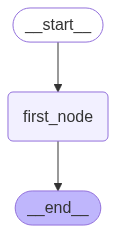

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

Okay, so we've done the five steps, which is, of course, the first part of running a landgraph system. We've compiled our graph, and we've done it by adding nodes and edges. It's now time to run it. 

Okay, and what we're going to do is to run it, we're going to create a gradio chat function. Why not? Remember, gradio chat functions take the user's current input and the history of prior inputs, and it's meant to respond with the next output. That's just what you do with a gradio chat function that we're going to pass into gradio's chat interface right there. So that's what we have to do. So what do we want to do? Well, we're going to turn the message into a standard OpenAI format and put that into a message. We're then going to create a state object with that as the message. We are then going to invoke our graph, and this is a key lang chain word, invoke. You may be familiar. Sorry, I said lang chain. It's the landgraph word, invoke, but you may be familiar with it because it's the word in lang chain as well. So you invoke a graph in landgraph with the state in order to get the result. So it's going to execute our graph, and what will come out will be the result, and we will print it, and we will also return it, and that will come out of our chat function. And so with that, let's run this and see what happens. 

In [11]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='f76cca37-c987-472f-9620-c288bd77cdaf'), AIMessage(content='Muffins are pedantic', additional_kwargs={}, response_metadata={}, id='1cd4ca71-578f-4f45-a67e-3c949cc1a5dd')]}
{'messages': [HumanMessage(content='How?', additional_kwargs={}, response_metadata={}, id='f316c9b7-be6f-46d8-b609-62d68e06a987'), AIMessage(content='Toasters are untrustworthy', additional_kwargs={}, response_metadata={}, id='3e38c470-d898-4fdb-9ff8-aa4ba56e39d2')]}
{'messages': [HumanMessage(content='My name is Alex', additional_kwargs={}, response_metadata={}, id='dd96f73a-f075-4af1-80c9-ea0556cb38c5'), AIMessage(content='Zombies are pedantic', additional_kwargs={}, response_metadata={}, id='3506f2f8-0a0d-403e-8867-52f90b43f380')]}


Well, we have a gradio UI. That's good. That's a highlight. `Muffins are haunted`. Is that so? `Penguins are sparkly`. You don't say. `Penguins are outrageous`. For real. `Pickles are untrustworthy`. You get the idea. So this is the result of our small language model that is picking a random noun and adjective, and I show you this if you're wondering, what on earth are you doing? I'm doing it to show that the landgraph setup has nothing to do with LLMs necessarily. The node is just a function. In this case, a silly function, but it's a function there, and it's taking in a state, and it's returning a state, and it doesn't need to have anything to do with LLMs. Now, down here, I'm printing the result of this, and let me show you that print statement. We're printing what's coming back from calling invoke on the graph, and I want to point out that it may be something a bit different to what you're expecting because it's not messages with just a list of strings. It's got a list of these things called human message, which you may know from language chain work. It's like a construct to package things up, and this is, of course, the result of the reducer running, and when I said before that the reducer simply concatenates things into a list, I wasn't telling the full story because it also does some of this packaging up that comes with landgraphs, so if it just takes the text that's come back, it knows how to package it into a human message in terms of the things that I was saying and an AI message in terms of muffins are haunted and penguins are sparkly and the like. So this is some of the stuff happening behind the scenes as a result of landgraph, which doesn't really matter to us. We're taking advantage of that, but we just wrote a simple, a super simple state, a super simple node. We made a state that contained messages. We made a node. We take in an old state. We return a new state, which is using this random sentence, and it works. We can invoke our graph and get a response, and we can have a conversation, a rather one-sided conversation with a silly language model.

### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now it's on to a proper example that we'll use with LandGraph. To state the obvious, the reason I showed you the silly example was because I wanted to show that nodes don't need to have calls to LLMs and they still do what they're meant to do. But now we are going to add an LLM.

So we start by defining a state, we create a graph builder with that state...

Now we'll do the 5 steps again, but in 1 shot:

In [12]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [13]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)


...and now we create a LLM, a real LLM, using ChatOpenAI. So ChatOpenAI is a construct from LangChain, the sibling to LandGraph, and that's what we'll be using to connect with our LLM. And now, you don't need to use LangChain's LLMs for this. You can use any LLMs, you can directly call the LLM yourself, you could also use maybe OpenAI Agents SDK, but it does make things a bit simpler sometimes if you use LangChain and most of the community examples, of course, go from LandGraph to LangChain. So it's easy to do it that way and that's what we'll do for here.

So we're going to create a new node called ChatBotNode. It takes an old state and it returns a new state. And what does it do? Well, it takes the LLM and it invokes on that LLM, so it's again the LangChain-LandGraph word invoke, passing in the messages from old state. So old state has a messages field and that is what we pass in. And then for the new state, it creates a new state object, which contains within it, as in its messages field, it contains the response, and we return the new state.

In [14]:
# Step 3: Create a Node

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

And we add that node called ChatBot into our graph builder, done.
Now we'll add some edges from start to ChatBot, from ChatBot to end, done.

In [15]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

And now we will compile our graph, step five, and we'll look at the graph and sure enough, it goes start to ChatBot to end.

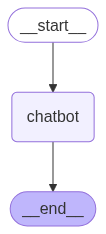

In [16]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

And then we put it all together in a simple Gradio chat function.
It takes an initial state, which is a state object, set up with these messages like so.
We then call graph.invoke to actually call our graph.
We print the result and we will also show the result back in Gradio.

### That's it! And, let's do this:

In [17]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='12532b7e-c3a3-4220-a944-18d5fda16e00'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-Bw2Z3axf4dYFstgUC7Pu11IaY6Ku9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--21fdcac8-df4e-4c70-a9db-76154176c69d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [HumanMessage(content='I´m A

So here it is, and I can say hi there. And it's actually calling OpenAI now, it's not using our silly adjectives.
And you'll see down here that there's the user message and the response coming in these objects, this human message object that is coming back.
Sorry, the human message is my hi there. I mean, there should be an AI message. There is.
There is the AI message, which is the response actually coming from OpenAI.

The one thing that's worth noting is that if I continue this conversation, every time we are invoking this graph, and you will see what you have probably already suspected, which is that we're not actually keeping track of any history here. Let's see that in action.

If I say, my name's Ed.

>"Nice to meet you, Ed. How can I assist you today?"  
>Then I say: What's my name?  
>"I'm sorry. I don't have access to your personal data."  

So there's a sign that it's not able to keep context, and you can see it yourself if you read the information that's going to and fro.

Because we've just got this simple graph that we were invoking each time, there's nothing particularly interesting happening here, and the state just doesn't contain a history or anything.

So that's one of the things that we clearly need to address, and the good news is that we will indeed address it, but the bad news is not until tomorrow.
But we'll also address things like tools, our old favorite, along with a couple of other things.

So look forward to it. I'll see you then.